In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

import torchvision
from torchvision import models, transforms
from torchvision.datasets import ImageFolder

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import cv2
from PIL import Image

import random
import time

try:
    from torchsummary import summary
except:
    !pip install torch_summary
    from torchsummary import summary
    
import os
import shutil
from glob import glob

import warnings
warnings.filterwarnings("ignore")

In [3]:
!git clone https://github.com/Almotasembelah/Age_Gender_Classification.git

Cloning into 'Age_Gender_Classification'...
remote: Enumerating objects: 116, done.
remote: Counting objects: 100% (116/116), done.
remote: Compressing objects: 100% (79/79), done.
remote: Total 116 (delta 27), reused 107 (delta 18), pack-reused 0 (from 0)
Receiving objects: 100% (116/116), 21.54 KiB | 4.31 MiB/s, done.
Resolving deltas: 100% (27/27), done.


In [4]:
import shutil

shutil.move('Age_Gender_Classification/models', 'models')
shutil.move('Age_Gender_Classification/utils', 'utils')
! rm -r Age_Gender_Classification

In [5]:
# import importlib
# import models, utils
# importlib.reload(utils)
# importlib.reload(models)
from utils.manager import *
from models.models import *
from models.cnn_model import *
from utils.data import *

In [6]:
root = '/kaggle/input/fairface/FairFace/'
train_csv = root + 'train_labels.csv'
val_csv = root + 'val_labels.csv'

# Explore the Date

In [7]:
train_labels = pd.read_csv(train_csv)
val_labels = pd.read_csv(val_csv)

In [8]:
train_labels.head()

,file,age,gender,race,service_test
0,train/1.jpg,50-59,Male,East Asian,True
1,train/2.jpg,30-39,Female,Indian,False
2,train/3.jpg,3-9,Female,Black,False
3,train/4.jpg,20-29,Female,Indian,True
4,train/5.jpg,20-29,Female,Indian,True


In [9]:
train_labels.describe()

,file,age,gender,race,service_test
count,86744,86744,86744,86744,86744
unique,86744,9,2,7,2
top,train/86744.jpg,20-29,Male,White,False
freq,1,25598,45986,16527,46492


In [10]:
def visualize_statics(column):
    counts_train = train_labels[column].value_counts()
    counts_val = val_labels[column].value_counts()
    print(f'{column} in Train_data has {train_labels[column].isnull().sum()} Null Values')
    print(f'{column} in Val_data has {val_labels[column].isnull().sum()} Null Values')
    fig, ax = plt.subplots(1, 2, figsize=(8, 6))
    if len(counts_train) > 2:
        ax[0].bar(counts_train.index.values, counts_train.values)
        ax[1].bar(counts_val.index.values, counts_val.values)  
        ax[0].tick_params(axis='x', rotation=45)  # Rotate x-axis labels
        ax[1].tick_params(axis='x', rotation=45)  # Rotate x-axis labels
    else:
        fig = ax[0].pie(labels=counts_train.index.values, x=counts_train.values, autopct='%1.1f%%')
        fig = ax[1].pie(labels=counts_val.index.values, x=counts_val.values, autopct='%1.1f%%')
    ax[0].set_title('Train Data')
    ax[1].set_title('Val Data')

gender in Train_data has 0 Null Values
gender in Val_data has 0 Null Values


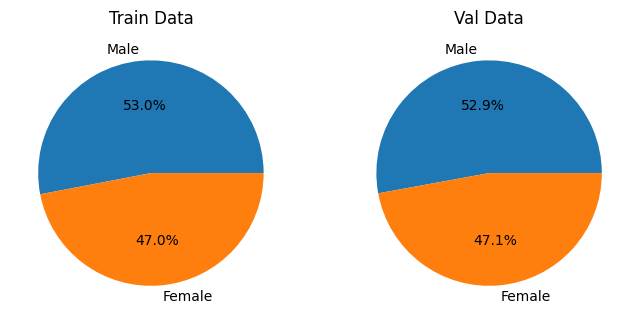

In [11]:
visualize_statics('gender')

age in Train_data has 0 Null Values
age in Val_data has 0 Null Values


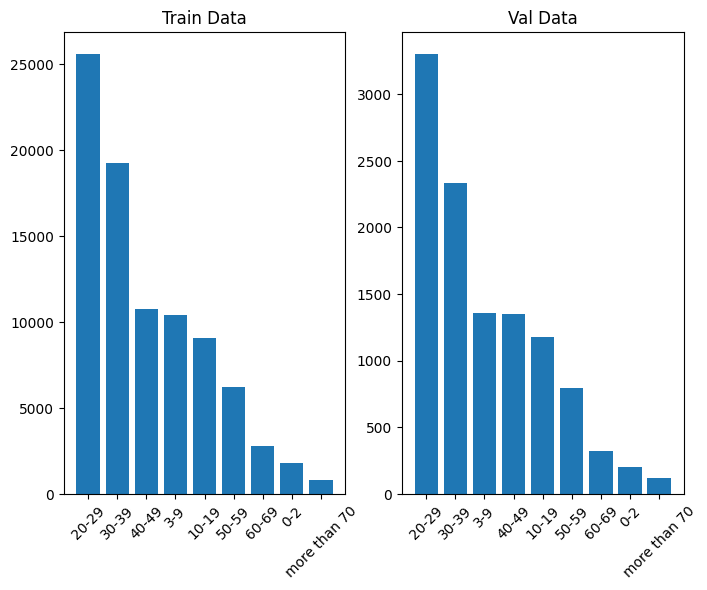

In [12]:
visualize_statics('age')

race in Train_data has 0 Null Values
race in Val_data has 0 Null Values


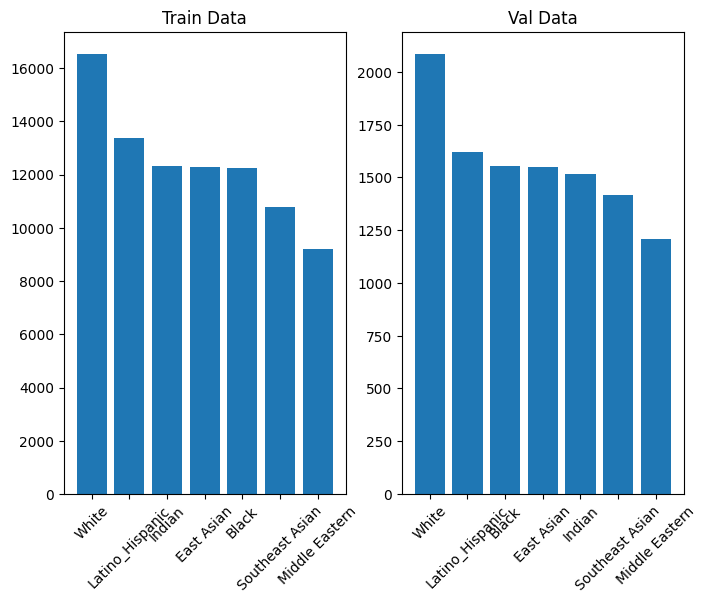

In [13]:
visualize_statics('race')

**As we can see, the dataset for age and race ist imbalanced, therefore we gonna balance it**

In [14]:
age_counts = train_labels['age'][:20000].value_counts()
race_counts = train_labels['race'][:20000].value_counts()

# Total number of samples
total_samples = sum(age_counts.values)
# Calculate weights
age_weights = {cls: total_samples / count for cls, count in zip(age_counts.index.values, age_counts.values)}
# Normalize weights
normalized_age_weights = {cls: weight / sum(age_weights.values()) for cls, weight in age_weights.items()}

# Total number of samples
total_samples = sum(race_counts.values)
# Calculate weights
race_weights = {cls: total_samples / count for cls, count in zip(race_counts.index.values, race_counts.values)}
# Normalize weights
normalized_race_weights = {cls: weight / sum(race_weights.values()) for cls, weight in race_weights.items()}
age_list = ['0-2','3-9','10-19','20-29', '30-39', '40-49','50-59','60-69','more than 70']
normalized_age_weights = {key: normalized_age_weights[key] for key in age_list}
print("Normalized Age Weights:\n", normalized_age_weights)
print("Normalized Race Weights:\n", normalized_race_weights)

Normalized Age Weights:
 {'0-2': 0.20332593254708875, '3-9': 0.03493486356495097, '10-19': 0.03903633235365378, '20-29': 0.014560692748091363, '30-39': 0.018791425946838653, '40-49': 0.03482008783249938, '50-59': 0.060346557916111036, '60-69': 0.1358764645386795, 'more than 70': 0.45830764255208656}
Normalized Race Weights:
 {'White': 0.10594046061183048, 'Latino_Hispanic': 0.12751589117261058, 'Black': 0.13906769803294852, 'East Asian': 0.140542435021633, 'Indian': 0.1414423865799359, 'Southeast Asian': 0.15961242419759125, 'Middle Eastern': 0.1858787043834501}


Age: 20-29 | Gender: Male | Race: White


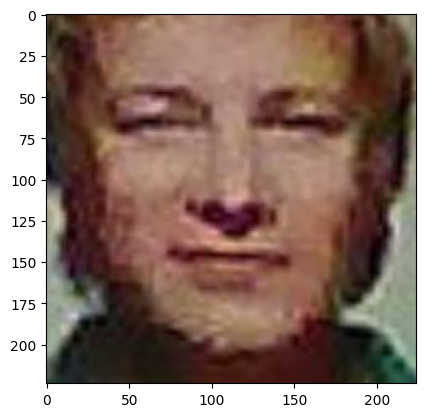

In [15]:
idx = random.choice(range(len(train_labels)-1))
img = plt.imread(root + train_labels.iloc[idx].file)
img_label = train_labels.iloc[idx]
print(f'Age: {img_label["age"]} | Gender: {img_label["gender"]} | Race: {img_label["race"]}')
plt.imshow(img)
plt.show()

# Load the Data


In [18]:
dummy_transform = transforms.Compose([transforms.Resize(224),
                                    transforms.ToTensor(),
                               ])
dummy_dataset = FairFaceDataset(train_labels[:20000], transform=dummy_transform)

tensor(0.) tensor(6) tensor(3)
Male 50-59 East Asian


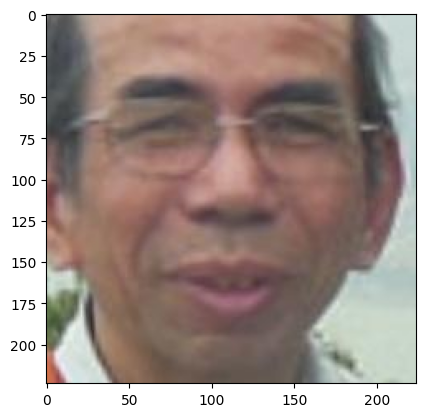

In [19]:
img, (gender, age, race) = dummy_dataset[10]
print(gender, age, race)
print(dummy_dataset.gender_classes[int(gender)],
      dummy_dataset.age_classes[int(age)], 
     dummy_dataset.race_classes[int(race)])
plt.imshow(img.permute(1, 2, 0).detach().numpy())

In [20]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [21]:
dummy_loader = DataLoader(dataset=dummy_dataset, batch_size=32)
normalizer = normalize(dummy_loader)

In [22]:
# normalizer = transforms.Normalize(mean=[0.4824, 0.3578, 0.3045], std=[0.2075, 0.1803, 0.1694])

In [23]:
cnn_transform = transforms.Compose([ 
                                transforms.ToTensor(),
                                normalizer,
                               ])

transform = transforms.Compose([ 
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485,0.456,0.406], #efficientnet_b0
                                                     std=[0.229,0.224,0.225]),
                               ])

# Define normalization transform for ResNet-18
transform_resnet = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),  
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


# Preparing Data for cnn_model
train_dataset_cnn = FairFaceDataset(train_labels[:20000], cnn_transform)
val_dataset_cnn = FairFaceDataset(val_labels[:10000], cnn_transform)

cnn_train_loader = DataLoader(dataset=train_dataset_cnn, batch_size=32, shuffle=True, drop_last=True)
cnn_val_loader = DataLoader(dataset=val_dataset_cnn, batch_size=32, drop_last=True)

# Preparing Data for efficientNet 
train_dataset = FairFaceDataset(train_labels[:20000], transform=transform)
val_dataset = FairFaceDataset(val_labels[:10000], transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True, drop_last=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, drop_last=True)

# Preparing Data for resnet 
train_dataset_resnet = FairFaceDataset(train_labels[:20000], transform=transform_resnet)
val_dataset_resnet = FairFaceDataset(val_labels[:10000], transform=transform_resnet)

train_loader_resnet = DataLoader(dataset=train_dataset_resnet, batch_size=32, shuffle=True, drop_last=True)
val_loader_resnet = DataLoader(dataset=val_dataset_resnet, batch_size=32, drop_last=True)

# Define the Model

**In this section, the models will be trained on subsamples, as training on the entire dataset takes a long time. Then, we will train the best model on the entire dataset.**

In [24]:
age_weights = torch.tensor(list(normalized_age_weights.values()), dtype=torch.float, device='cuda')
race_weights = torch.tensor(list(normalized_race_weights.values()), dtype=torch.float, device='cuda')

gender_loss_fn = nn.BCELoss(reduction='mean')
race_loss_fn = nn.CrossEntropyLoss(reduction='mean', weight=race_weights)
age_loss_fn = nn.CrossEntropyLoss(reduction='mean', weight=age_weights)

## ModelV1

In [25]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
cnn_model = ModelV1()
optimizer_cnn = optim.Adam(cnn_model.parameters(), lr=0.01)
# summary(cnn_model.to(device), (3, 224, 224))

In [26]:
model_manager = ModelManager(cnn_model, optimizer_cnn, [gender_loss_fn, age_loss_fn, race_loss_fn])
model_manager.set_dataloaders(cnn_train_loader, cnn_val_loader)
model_manager.set_tasks_names('Gen', 'Age', 'Race')
scheduler_cnn = ReduceLROnPlateau(optimizer_cnn, patience=3, threshold=0.001)
model_manager.set_lr_scheduler(scheduler_cnn)

In [27]:
model_manager.train(5, display_table=True)

,Epoch,Training Loss,Validation Loss,Gen Loss (Train),Gen Loss (Val),Age Loss (Train),Age Loss (Val),Race Loss (Train),Race Loss (Val),Gen Acc (Train),Gen Acc (Val),Age Acc (Train),Age Acc (Val),Race Acc (Train),Race Acc (Val),Learning Rate
0,1,4.9824,4.8336,0.7142,0.6889,2.2703,2.1956,1.9978,1.9491,53.83%,53.06%,14.04%,12.29%,14.71%,12.92%,0.010
1,2,4.8297,4.8334,0.6884,0.6927,2.1940,2.1947,1.9474,1.9460,54.27%,50.72%,16.30%,30.18%,15.13%,19.08%,0.010
2,3,4.8321,4.8343,0.6912,0.6913,2.1942,2.1957,1.9467,1.9473,53.12%,53.06%,16.09%,10.94%,15.41%,14.05%,0.010
3,4,4.8344,4.8318,0.6923,0.6914,2.1951,2.1938,1.9470,1.9466,52.76%,53.06%,16.76%,30.18%,14.76%,11.05%,0.010
4,5,4.8339,4.8324,0.6920,0.6913,2.1946,2.1934,1.9473,1.9477,52.76%,53.06%,18.96%,7.25%,14.27%,19.09%,0.001


## Train ResNet18

In [28]:
model = ResNet18(1024, Task.ALL)
optimizer = optim.Adam(lr=0.001, params = model.parameters())

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 192MB/s]


In [29]:
summary(model.to(device), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [30]:
mm = ModelManager(model, optimizer, [gender_loss_fn, age_loss_fn, race_loss_fn])
mm.set_dataloaders(train_loader_resnet, val_loader_resnet)
mm.set_tasks_names('Gen', 'Age', 'Race')
scheduler = ReduceLROnPlateau(optimizer, patience=3, threshold=0.001)
mm.set_lr_scheduler(scheduler)

In [31]:
mm.train(5, display_table=True)

,Epoch,Training Loss,Validation Loss,Gen Loss (Train),Gen Loss (Val),Age Loss (Train),Age Loss (Val),Race Loss (Train),Race Loss (Val),Gen Acc (Train),Gen Acc (Val),Age Acc (Train),Age Acc (Val),Race Acc (Train),Race Acc (Val),Learning Rate
0,1,3.9894,3.8043,0.5655,0.5511,1.7348,1.6729,1.6891,1.5804,70.95%,70.54%,27.05%,29.05%,35.24%,36.92%,0.001
1,2,3.6494,3.7507,0.5145,0.5113,1.5671,1.6833,1.5677,1.5561,74.71%,74.29%,31.09%,26.71%,40.71%,39.85%,0.001
2,3,3.4880,3.6563,0.4914,0.5085,1.4959,1.6210,1.5007,1.5268,76.61%,73.88%,32.68%,27.89%,44.33%,40.76%,0.001
3,4,3.3253,3.6865,0.4724,0.4826,1.4151,1.6277,1.4378,1.5763,78.11%,75.94%,35.19%,29.52%,47.10%,40.67%,0.001
4,5,3.1535,3.6959,0.4427,0.4887,1.3431,1.6988,1.3677,1.5083,79.86%,75.47%,37.23%,25.31%,50.44%,40.79%,0.001


## Training the Model without Freezing Layers

In [32]:
resnet_nf = ResNet18(1024, Task.ALL, freeze=False)
optimizer_nf = optim.Adam(lr=0.001, params = resnet_nf.parameters())
resnet_mm = ModelManager(resnet_nf, optimizer_nf, [gender_loss_fn, age_loss_fn, race_loss_fn])

resnet_mm.set_dataloaders(cnn_train_loader, cnn_val_loader)
resnet_mm.set_tasks_names('Gen', 'Age', 'race')
scheduler_nf = ReduceLROnPlateau(optimizer_nf, patience=3, threshold=0.001)
resnet_mm.set_lr_scheduler(scheduler_nf)

In [33]:
resnet_mm.train(5, display_table=True) 

,Epoch,Training Loss,Validation Loss,Gen Loss (Train),Gen Loss (Val),Age Loss (Train),Age Loss (Val),race Loss (Train),race Loss (Val),Gen Acc (Train),Gen Acc (Val),Age Acc (Train),Age Acc (Val),race Acc (Train),race Acc (Val),Learning Rate
0,1,4.0393,3.5841,0.5521,0.5930,1.7709,1.5207,1.7163,1.4703,69.72%,72.13%,24.93%,32.28%,31.49%,44.29%,0.001
1,2,3.2339,3.2188,0.3946,0.3458,1.4471,1.4897,1.3922,1.3834,81.65%,83.64%,34.73%,32.91%,46.79%,46.54%,0.001
2,3,2.8543,2.9720,0.3265,0.3879,1.2914,1.2936,1.2364,1.2906,86.42%,82.02%,40.67%,39.48%,53.16%,49.55%,0.001
3,4,2.5819,2.8339,0.2901,0.3114,1.1755,1.2900,1.1163,1.2324,88.68%,86.04%,44.21%,44.77%,58.66%,51.87%,0.001
4,5,2.3252,2.7554,0.2517,0.3067,1.0550,1.3139,1.0185,1.1348,90.91%,86.17%,49.10%,42.99%,62.64%,56.11%,0.001


## Train EfficientNet_b0

In [34]:
eff_net = EfficientNetB0(1024, Task.ALL)
optimizer_eff_net = optim.Adam(lr=0.001, params = eff_net.parameters())
effnet_mm = ModelManager(eff_net, optimizer_eff_net, [gender_loss_fn, age_loss_fn, race_loss_fn])
effnet_mm.set_dataloaders(train_loader, val_loader)
effnet_mm.set_tasks_names('Gen', 'Age', 'Race')
scheduler_effnet = ReduceLROnPlateau(optimizer_eff_net, patience=3, threshold=0.001)
effnet_mm.set_lr_scheduler(scheduler_effnet)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 91.2MB/s]


In [35]:
effnet_mm.train(5, display_table=True)

,Epoch,Training Loss,Validation Loss,Gen Loss (Train),Gen Loss (Val),Age Loss (Train),Age Loss (Val),Race Loss (Train),Race Loss (Val),Gen Acc (Train),Gen Acc (Val),Age Acc (Train),Age Acc (Val),Race Acc (Train),Race Acc (Val),Learning Rate
0,1,4.0193,3.7412,0.5579,0.5243,1.7458,1.6049,1.7155,1.6120,72.86%,72.58%,27.11%,29.18%,35.19%,37.39%,0.001
1,2,3.6202,3.6632,0.4955,0.4931,1.5558,1.6088,1.5689,1.5613,77.33%,74.79%,32.16%,26.45%,42.84%,40.07%,0.001
2,3,3.4162,3.5850,0.4700,0.4791,1.4544,1.5740,1.4918,1.5319,79.20%,76.31%,34.31%,33.63%,47.10%,41.29%,0.001
3,4,3.2716,3.6211,0.4504,0.4721,1.3962,1.6196,1.4249,1.5295,81.17%,76.47%,36.70%,29.83%,50.83%,42.36%,0.001
4,5,3.1210,3.6106,0.4268,0.4725,1.3308,1.6124,1.3634,1.5257,82.72%,75.61%,38.98%,32.12%,54.38%,42.36%,0.001


## EfficientNetB0 without Freezing Layers


In [36]:
eff_net_nf = EfficientNetB0(1024, Task.ALL, freeze=False)
optimizer_eff_net_nf = optim.Adam(lr=0.001, params = eff_net_nf.parameters())
effnet_mm_nf = ModelManager(eff_net_nf, optimizer_eff_net_nf, [gender_loss_fn, age_loss_fn, race_loss_fn])
effnet_mm_nf.set_dataloaders(cnn_train_loader, cnn_val_loader)
effnet_mm_nf.set_tasks_names('Gen', 'Age', 'Race')
scheduler_effnet_nf = ReduceLROnPlateau(optimizer_eff_net_nf, patience=3, threshold=0.001)
effnet_mm_nf.set_lr_scheduler(scheduler_effnet_nf)

In [37]:
effnet_mm_nf.train(5, display_table=True)

,Epoch,Training Loss,Validation Loss,Gen Loss (Train),Gen Loss (Val),Age Loss (Train),Age Loss (Val),Race Loss (Train),Race Loss (Val),Gen Acc (Train),Gen Acc (Val),Age Acc (Train),Age Acc (Val),Race Acc (Train),Race Acc (Val),Learning Rate
0,1,3.3875,3.0129,0.4121,0.2948,1.5497,1.4837,1.4257,1.2344,82.89%,86.74%,35.96%,35.80%,49.41%,52.11%,0.001
1,2,2.6432,2.7182,0.2868,0.3375,1.2268,1.2431,1.1296,1.1376,89.80%,84.99%,45.93%,41.03%,61.44%,56.10%,0.001
2,3,2.3520,2.5576,0.2389,0.2492,1.1076,1.2341,1.0056,1.0743,92.28%,88.91%,49.26%,45.46%,65.93%,58.47%,0.001
3,4,2.1450,2.4786,0.2129,0.2548,1.0182,1.1921,0.9139,1.0317,93.56%,88.96%,53.05%,42.54%,70.25%,59.25%,0.001
4,5,1.9838,2.5234,0.1897,0.2490,0.9449,1.2091,0.8492,1.0653,94.30%,89.40%,55.38%,46.41%,73.11%,59.83%,0.001


## Change the Classification Layer

Instead of creating separate fully connected (FC) layers for each task, we will create a single FC layer. The output of this layer will be the sum of all classes: `1` for Gender, `9` for Age, and `7` for Race.

In [44]:
transform = transforms.Compose([transforms.Resize((224,224)),
                               transforms.ToTensor(),
                               # normalizer
                               ])
# Preparing Data for efficientNet 
train_mlt_dataset = FairFaceDataset(train_labels[:20000], transform=transform)
val_mlt_dataset = FairFaceDataset(val_labels[:5000], transform=transform)

train_mlt_loader = DataLoader(dataset=train_mlt_dataset, batch_size=32, shuffle=True, drop_last=True)
val_mlt_loader = DataLoader(dataset=val_mlt_dataset, batch_size=32, drop_last=True)

In [45]:
torch.cuda.manual_seed(42)
torch.manual_seed(42)
gen_loss_fn_nl = nn.BCEWithLogitsLoss()
mlt_model = EfficientNetB0(1024, Task.AGE, freeze=False)
mlt_model.model.classifier.fc_age = nn.Sequential(
                                                    nn.Linear(1280, 1024, bias=False),
                                                    nn.BatchNorm1d(1024),
                                                    nn.ReLU(inplace=True),
                                                    nn.Linear(1024, 512, bias=False),
                                                    nn.BatchNorm1d(512),
                                                    nn.ReLU(inplace=True),
                                                    nn.Linear(512, 17),
                                                    )
mlt_optimizer = optim.Adam(lr=0.001, params = mlt_model.parameters())
mlt_mm = ModelManagerV2(mlt_model, mlt_optimizer, [gen_loss_fn_nl, age_loss_fn, race_loss_fn])
mlt_mm.set_dataloaders(train_mlt_loader, val_mlt_loader)
mlt_scheduler = ReduceLROnPlateau(mlt_optimizer, patience=3, threshold=0.001)
mlt_mm.set_lr_scheduler(mlt_scheduler)
mlt_mm.set_tasks_names('Gen', 'Age', 'Race')

In [46]:
mlt_mm.train(5, display_table=True) 

,Epoch,Training Loss,Validation Loss,Gen Loss (Train),Gen Loss (Val),Age Loss (Train),Age Loss (Val),Race Loss (Train),Race Loss (Val),Gen Acc (Train),Gen Acc (Val),Age Acc (Train),Age Acc (Val),Race Acc (Train),Race Acc (Val),Learning Rate
0,1,3.5109,3.1011,0.4430,0.3273,1.5652,1.4202,1.5028,1.3537,79.43%,84.54%,33.26%,41.69%,45.52%,48.76%,0.001
1,2,2.7757,2.7511,0.3057,0.2591,1.2761,1.2743,1.1938,1.2178,87.84%,87.02%,44.11%,42.67%,58.70%,52.70%,0.001
2,3,2.5095,2.5217,0.2611,0.2479,1.1711,1.1778,1.0772,1.0960,90.53%,88.14%,47.59%,45.99%,63.23%,57.45%,0.001
3,4,2.2890,2.5724,0.2324,0.2474,1.0684,1.2589,0.9882,1.0661,91.88%,88.36%,51.36%,43.37%,67.95%,58.73%,0.001
4,5,2.1317,2.4469,0.2093,0.2327,1.0091,1.1907,0.9134,1.0234,93.39%,89.48%,53.55%,48.00%,70.43%,61.64%,0.001


In [52]:
mlt_mm.train(5, display_table=True) 

,Epoch,Training Loss,Validation Loss,Gen Loss (Train),Gen Loss (Val),Age Loss (Train),Age Loss (Val),Race Loss (Train),Race Loss (Val),Gen Acc (Train),Gen Acc (Val),Age Acc (Train),Age Acc (Val),Race Acc (Train),Race Acc (Val),Learning Rate
0,6,1.9679,2.4952,0.1857,0.2353,0.9352,1.2043,0.8470,1.0556,94.58%,89.82%,56.19%,50.44%,73.73%,60.04%,0.0010
1,7,1.8232,2.7979,0.1732,0.2426,0.8759,1.4351,0.7742,1.1202,95.30%,89.26%,58.02%,47.24%,76.61%,60.72%,0.0010
2,8,1.6882,2.6248,0.1515,0.2460,0.8285,1.2696,0.7081,1.1092,96.41%,89.26%,60.73%,46.85%,79.66%,60.54%,0.0010
3,9,1.5416,2.7923,0.1391,0.2600,0.7672,1.3802,0.6353,1.1521,96.65%,89.28%,63.95%,46.41%,82.83%,59.74%,0.0001
4,10,1.1128,2.5541,0.0883,0.2238,0.6033,1.2610,0.4211,1.0693,97.94%,90.81%,70.05%,50.50%,89.38%,64.26%,0.0001
